- 系统环境：windows
- python版本：3.6.4
- pytorch版本：1.0.1

In [1]:
# 加载模块
import torch.nn as nn
import torch
import numpy as np
import torch.optim as optim
import torchvision
import torch.autograd as autograd
import matplotlib.pyplot as plt


In [2]:
# 加载mnist数据集
train_set = torchvision.datasets.MNIST("mnist/train",train=True,transform=torchvision.transforms.ToTensor(),download=True)
test_set = torchvision.datasets.MNIST("mnist/test",train=False,transform=torchvision.transforms.ToTensor(),download=True)

# 把数据集分为 128 的mini-batch
train_dataset = torch.utils.data.DataLoader(train_set,batch_size=128, shuffle=True)
test_dataset = torch.utils.data.DataLoader(test_set,batch_size=100, shuffle=False)

In [3]:
# 实现含有2个hidden layer的多层感知机，结构：784 -> 512 -> 128 -> 10
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.fc1 =nn.Linear(784,512)
        self.fc2 =nn.Linear(512,128)
        self.fc3 =nn.Linear(128,10)

    def forward(self, x):
        x = x.view(-1,28*28)
        # hidden layer使用 ReLU激活函数
        dout =nn.functional.relu(self.fc1(x))
        dout =nn.functional.relu(self.fc2(dout))
        # 输出层使用softmax激活函数
        return self.fc3(dout)

In [4]:
# 计算准确率
def AccuarcyCompute(pred, label):
    pred = pred.cpu().data.numpy()
    label = label.cpu().data.numpy()
    test_np = (np.argmax(pred,1) == label)
    test_np = np.float32(test_np)
    return np.mean(test_np)

In [5]:
# 实例化模型并打印模型结构
torch.manual_seed(1)
model = MLP().cuda()
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [6]:
# 采用带 momentum 的 SGD方法，并定义学习率的下降规则
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 定义学习率下降策略
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [5, 6], gamma=1, last_epoch=-1)

# 使用交叉熵损失函数
lossfunc = nn.CrossEntropyLoss().cuda()

epoch 0
0 : 0.1171875
100 : 0.9453125
200 : 0.9453125
300 : 0.9296875
400 : 0.953125
epoch 1
0 : 0.9296875
100 : 0.9765625
200 : 0.984375
300 : 0.9765625
400 : 0.9375
epoch 2
0 : 0.9765625
100 : 0.9609375
200 : 0.953125
300 : 0.96875
400 : 0.984375
epoch 3
0 : 0.9921875
100 : 0.96875
200 : 0.9609375
300 : 0.9609375
400 : 0.9609375
epoch 4
0 : 0.96875
100 : 0.9921875
200 : 0.9921875
300 : 0.984375
400 : 0.9609375
epoch 5
0 : 0.984375
100 : 0.96875
200 : 1.0
300 : 0.984375
400 : 0.9765625
epoch 6
0 : 0.9921875
100 : 0.9921875
200 : 0.9765625
300 : 0.9765625
400 : 0.9765625
epoch 7
0 : 0.9609375
100 : 0.9765625
200 : 0.984375
300 : 0.984375
400 : 0.984375


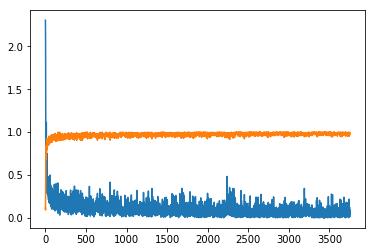

In [7]:
accuarcys = []
losses = []
# 在train_dataset上训练模型，一共11个epoch
for x in range(8):
    print('epoch ' + str(x))
    # 在每个mini-batch上迭代
    for i, data in enumerate(train_dataset):
        
        # 初始化梯度
        optimizer.zero_grad()

        (inputs,labels) = data
        inputs = autograd.Variable(inputs).cuda()
        labels = autograd.Variable(labels).cuda()

        # 前向传播
        outputs = model(inputs)

        # 计算损失
        loss = lossfunc(outputs,labels)
        
        # 反向传播
        loss.backward()

        # 更新网络参数
        optimizer.step()
        
        losses.append(loss)
        
        accuarcys.append(AccuarcyCompute(outputs,labels))
        
        # 每一百次iteration打印在训练集上的准确率
        if i % 100 == 0:
            print(i,":",accuarcys[-1])
            
    # 打印当前 epoch 的学习率
#     print('learning rate is : %g' % scheduler.get_lr()[0])
    # 学习率变为上一个epoch 的 0.01
#     scheduler.step()
    
# 绘制 loss 变化曲线和准确率变化曲线
plt.plot(losses)
plt.plot(accuarcys)
plt.show()

In [8]:
# 计算模型在测试集上的正确率
accuarcy_list = []
for i, (inputs,labels) in enumerate(test_dataset):
    inputs = autograd.Variable(inputs).cuda()
    labels = autograd.Variable(labels).cuda()
    outputs = model(inputs)
    accuarcy_list.append(AccuarcyCompute(outputs,labels))
print(sum(accuarcy_list) / len(accuarcy_list))

0.9710000050067902


In [9]:
# 保存模型参数
torch.save(model.state_dict(), 'net_params')